In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Step 1: Load and Preprocess Data
# -----------------------------
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/household_power_consumption.zip',
                 compression='zip', sep=';', low_memory=False, na_values='?')

# Combine date and time, convert to datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
df.set_index('Datetime', inplace=True)

# Keep only 'Global_active_power' and convert to float
df = df[['Global_active_power']].astype(float)
df.dropna(inplace=True)

# Resample to hourly mean
df_hourly = df.resample('H').mean()


In [3]:
# Step 2: Feature Engineering
# -----------------------------
df_feat = df_hourly.copy()
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['is_weekend'] = (df_feat['dayofweek'] >= 5).astype(int)


In [4]:
# Step 3: Train-Test Split
# -----------------------------
train = df_feat.iloc[:-168]   # last 7 days for test
test = df_feat.iloc[-168:]

In [5]:
# Step 4: ARIMA Forecasting
# -----------------------------
arima_model = ARIMA(train['Global_active_power'], order=(2,1,2))
arima_fit = arima_model.fit()
arima_pred = arima_fit.forecast(steps=168)

In [6]:
# Step 5: Prophet Forecasting
# -----------------------------
prophet_df = train.reset_index()[['Datetime', 'Global_active_power']]
prophet_df.columns = ['ds', 'y']

model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=True)
model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=168, freq='H')
forecast = model_prophet.predict(future)
prophet_pred = forecast[['ds', 'yhat']].set_index('ds').iloc[-168:]['yhat']

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkdhh81hb/lr0dko9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkdhh81hb/85or13kt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3710', 'data', 'file=/tmp/tmpkdhh81hb/lr0dko9y.json', 'init=/tmp/tmpkdhh81hb/85or13kt.json', 'output', 'file=/tmp/tmpkdhh81hb/prophet_modelsyi90_79/prophet_model-20250724121243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [7]:
# Step 6: XGBoost Forecasting
# -----------------------------
# Shift target to forecast next hour
df_feat['target'] = df_feat['Global_active_power'].shift(-1)
df_feat.dropna(inplace=True)

X = df_feat[['hour', 'dayofweek', 'is_weekend']]
y = df_feat['target']

X_train, y_train = X.iloc[:-168], y.iloc[:-168]
X_test, y_test = X.iloc[-168:], y.iloc[-168:]

xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)


In [8]:
# Step 7: Evaluation
# -----------------------------
def evaluate(true, pred, model_name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f'{model_name} - MAE: {mae:.3f}, RMSE: {rmse:.3f}')
    return mae, rmse

print("\nModel Evaluation:")
evaluate(test['Global_active_power'], arima_pred, "ARIMA")
evaluate(test['Global_active_power'], prophet_pred, "Prophet")
evaluate(y_test, xgb_pred, "XGBoost")


Model Evaluation:
ARIMA - MAE: 0.695, RMSE: 0.856
Prophet - MAE: 0.511, RMSE: 0.755
XGBoost - MAE: 0.482, RMSE: 0.688


(0.4818732070769583, np.float64(0.6883593330162924))

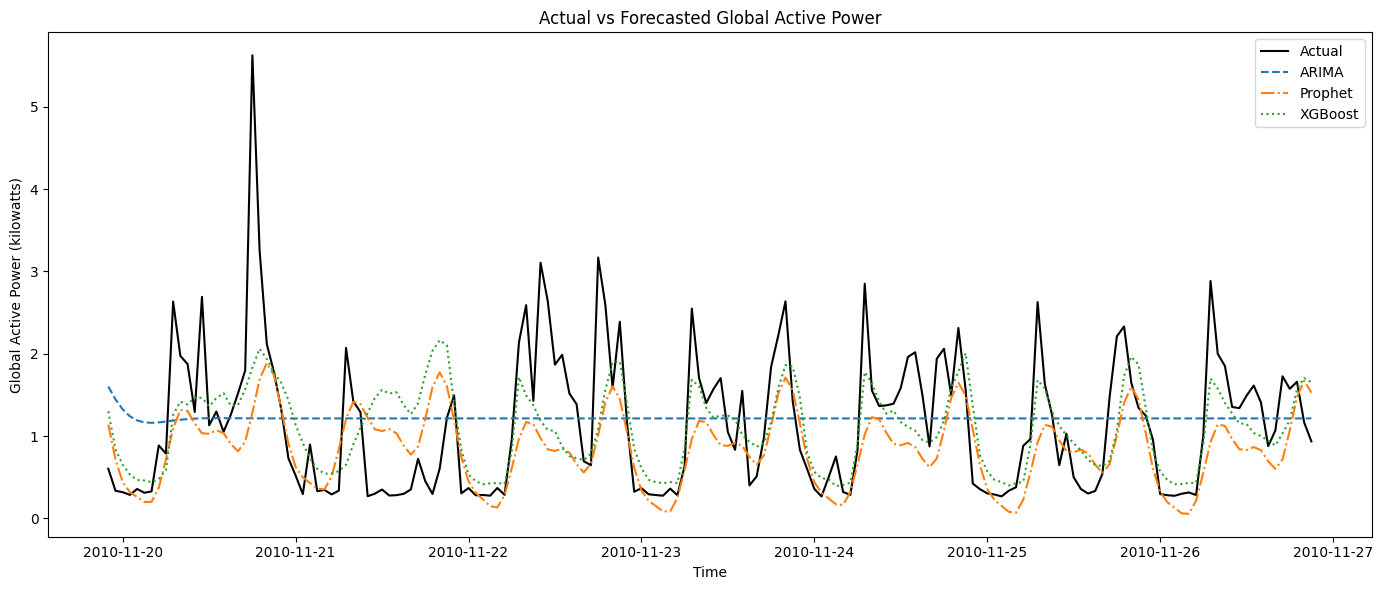

In [9]:
# Step 8: Visualization
# -----------------------------
plt.figure(figsize=(14,6))
plt.plot(test.index, test['Global_active_power'], label='Actual', color='black')
plt.plot(test.index, arima_pred, label='ARIMA', linestyle='--')
plt.plot(test.index, prophet_pred, label='Prophet', linestyle='-.')
plt.plot(test.index, xgb_pred, label='XGBoost', linestyle=':')
plt.title('Actual vs Forecasted Global Active Power')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.tight_layout()
plt.show()